In [16]:
## AUXILIAR: IMPORTS GLOBALES
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, KFold
from sklearn.metrics import r2_score, root_mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [17]:
## AUXILIAR: Muestra los resultados de cada modelo.

def mostrar_resultados_regresion(y_real, y_predicho, titulo="Resultados"):
    rmse = root_mean_squared_error(y_real, y_predicho)
    r2 = r2_score(y_real, y_predicho)
    print(f"\n{titulo}:")
    print(f"R²  : {r2:.6f}")
    print(f"RMSE: {rmse:.6f}")

In [18]:
## AUXILIAR: División en training set y test set. (Split 80-20)

def split_80_20_regresion(df: pd.DataFrame, columna_objetivo: str):
    atributos = df.drop(columns=columna_objetivo)
    objetivo = df[columna_objetivo]
    X_train, X_test, y_train, y_test = train_test_split(
        atributos, objetivo, test_size=0.2, random_state=42
    )
    return X_train, X_test, y_train, y_test

In [19]:
# Carga de datos
dataset = pd.read_csv('../datasets/carprices.csv')

#### LIMPIEZA

In [20]:
# Análisis Exploratorio.

print("\nInfo general del dataset:")
dataset.head()
dataset.info()

print("\nValores faltantes por atributo:")
print(dataset.isnull().sum().sort_values(ascending=False))

print("\nDuplicados:", dataset.duplicated().sum())


Info general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  


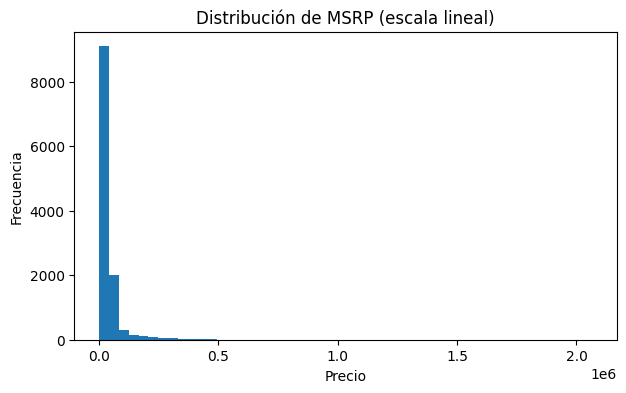

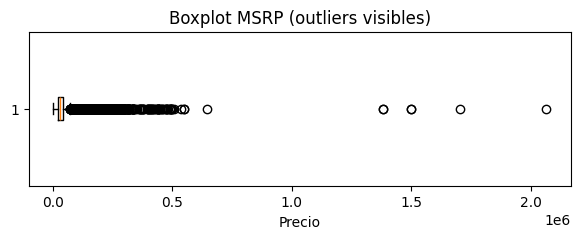

In [21]:
# Análisis de distribución
y = dataset["MSRP"]

plt.figure(figsize=(7,4))
plt.hist(y, bins=50)
plt.title("Distribución de MSRP (escala lineal)")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.show()

# Boxplot para outliers
plt.figure(figsize=(7,2))
plt.boxplot(y, vert=False, showfliers=True)
plt.title("Boxplot MSRP (outliers visibles)")
plt.xlabel("Precio")
plt.show()

In [22]:
# Imputación.

""" 
Se proceden a imputar los valores nulos de los atributos del dataset.
- Para atributos continuos, se utilizará la mediana.
- Para atributos categóricos, se utilizará la moda.
"""

# Columnas numéricas.
for col in ["Engine HP", "Engine Cylinders", "Number of Doors"]:
    if col in dataset.columns:
        dataset[col] = dataset[col].fillna(dataset[col].median())

# Columnas categóricas.
for col in ["Engine Fuel Type"]:
    if col in dataset.columns:
        dataset[col] = dataset[col].fillna(dataset[col].mode()[0])

# Verificación.
print("\nValores faltantes por atributo:")
print(dataset.isnull().sum())

dataset.head()


Valores faltantes por atributo:
Make                    0
Model                   0
Year                    0
Engine Fuel Type        0
Engine HP               0
Engine Cylinders        0
Transmission Type       0
Driven_Wheels           0
Number of Doors         0
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


#### INTEGRACIÓN

#### SELECCIÓN

In [23]:
# Análisis de correlación

df_corr = dataset.copy()

# Asegurarnos de que los nombres existan (algunos datasets usan MAY/MIN distinto)
cols_presentes = df_corr.columns.str.lower()
map_col = {c.lower(): c for c in df_corr.columns}  # para mapear al nombre real

def get_col(name_lower):
    assert name_lower in cols_presentes, f"Columna '{name_lower}' no está en el dataframe"
    return map_col[name_lower]

col_city = get_col("city mpg")
col_hwy  = get_col("highway mpg") if "highway mpg" in cols_presentes else get_col("highway mpg".replace("mpg", "mpg"))  # alias defensivo
col_cyl  = get_col("engine cylinders")
col_hp   = get_col("engine hp")

pearson_city_hwy = df_corr[[col_city, col_hwy]].corr(method='pearson').iloc[0,1]
pearson_cyl_hp   = df_corr[[col_cyl, col_hp]].corr(method='pearson').iloc[0,1]

print(f"Correlación lineal: {col_city} vs {col_hwy}: {pearson_city_hwy:.3f}")
print(f"Correlación lineal: {col_cyl} vs {col_hp}: {pearson_cyl_hp:.3f}")

Correlación lineal: city mpg vs highway MPG: 0.887
Correlación lineal: Engine Cylinders vs Engine HP: 0.767


In [24]:
# Filtrado de outliers del atributo objetivo (MSRP)

q1 = dataset["MSRP"].quantile(0.25)
q3 = dataset["MSRP"].quantile(0.75)
iqr = q3 - q1
lim_inf = q1 - 1.5 * iqr
lim_sup = q3 + 1.5 * iqr

antes = len(dataset)
dataset = dataset[(dataset["MSRP"] >= lim_inf) & (dataset["MSRP"] <= lim_sup)]
despues = len(dataset)
print(f"Filtrado de outliers por IQR en MSRP: removidos {antes - despues} registros ({(antes - despues)/antes:.2%}).")

Filtrado de outliers por IQR en MSRP: removidos 996 registros (8.36%).


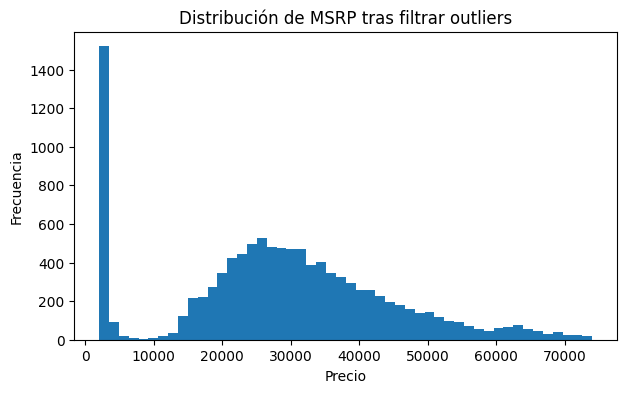

In [25]:
# Validar distribución nuevamente

plt.figure(figsize=(7,4))
plt.hist(dataset["MSRP"], bins=50)
plt.title("Distribución de MSRP tras filtrar outliers")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.show()

In [26]:
# Eliminación en 'Selección' (criterio de utilidad/colinealidad/alta cardinalidad)
cols_a_eliminar = [
    "Market Category",    # demasiados valores nulos, muchas categorías, no útil
    "Model",              # demasiadas categorías, redundante con Make
    "Engine Cylinders",   # fuertemente relacionada con potencia (HP)
    "Vehicle Size",       # redundante según análisis gráfico
    "city mpg"            # muy correlacionada con highway MPG
]

dataset = dataset.drop(columns=[c for c in cols_a_eliminar if c in dataset.columns], errors='ignore')

# Verificación
dataset.head()

,Make,Year,Engine Fuel Type,Engine HP,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Style,highway MPG,Popularity,MSRP
0,BMW,2011,premium unleaded (required),335.0,MANUAL,rear wheel drive,2.0,Coupe,26,3916,46135
1,BMW,2011,premium unleaded (required),300.0,MANUAL,rear wheel drive,2.0,Convertible,28,3916,40650
2,BMW,2011,premium unleaded (required),300.0,MANUAL,rear wheel drive,2.0,Coupe,28,3916,36350
3,BMW,2011,premium unleaded (required),230.0,MANUAL,rear wheel drive,2.0,Coupe,28,3916,29450
4,BMW,2011,premium unleaded (required),230.0,MANUAL,rear wheel drive,2.0,Convertible,28,3916,34500


#### TRANSFORMACIÓN

In [27]:
"""
- Se agrupan tipos de combustible a una nueva variable Fuel Group. (TO DO)
- Se aplica una transformación a números con One Hot Encoding para atributos
  categóricos multiclase donde las clases no tienen un orden particular.
"""

# Agrupar combustible a grupos generales
def agrupar_combustible(valor: str) -> str:
    v = str(valor).lower()
    if 'premium' in v:
        return 'Premium'
    if 'regular' in v or 'gasoline' in v or 'petrol' in v:
        return 'Regular'
    return 'Especial'

if "Engine Fuel Type" in dataset.columns:
    dataset["Fuel Group"] = dataset["Engine Fuel Type"].apply(agrupar_combustible)
    dataset = dataset.drop(columns=["Engine Fuel Type"])

# One-Hot Encoding de categóricas
categoricas = [c for c in ["Make", "Driven_Wheels", "Vehicle Style", "Transmission Type", "Fuel Group"] if c in dataset.columns]
dataset = pd.get_dummies(dataset, columns=categoricas, drop_first=True)

# Definir atributos/objetivo (TO DO)
objetivo_col = "MSRP"
atributos = dataset.drop(columns=objetivo_col)
objetivo = dataset[objetivo_col]

print("Dimensiones tras OHE:", atributos.shape)

Dimensiones tras OHE: (10918, 67)


In [28]:
"""
Se aplica un escalado con StandardScaler() para los atributos categóricos continuos.
Este escalado se aplica en los propios training set al momento de hacer el split, y no
en todo el dataset dado que provoca filtración de data y no eso puede sesgar las métricas
de los modelos (el test set gana información sobre el training set que no debería saber).
"""

'\nSe aplica un escalado con StandardScaler() para los atributos categóricos continuos.\nEste escalado se aplica en los propios training set al momento de hacer el split, y no\nen todo el dataset dado que provoca filtración de data y no eso puede sesgar las métricas\nde los modelos (el test set gana información sobre el training set que no debería saber).\n'

#### MINERÍA Y EVALUACIÓN

In [ ]:
# Regresión Lineal
from sklearn.linear_model import Ridge

pipe_LR = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("modelo", LinearRegression())
])

kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
pred_oof = cross_val_predict(pipe_LR, atributos, objetivo, cv=kf5, n_jobs=-1)
mostrar_resultados_regresion(objetivo, pred_oof, titulo="Regresión Lineal - Cross-validation")

atributos_train, atributos_test, objetivo_train, objetivo_test = split_80_20_regresion(dataset, objetivo_col)

pipe_Ridge = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("modelo", Ridge())
])

param_Ridge = {
    "modelo__alpha": [0.1, 1.0, 10.0, 100.0]
}

grid_Ridge = GridSearchCV(
    estimator=pipe_Ridge,
    param_grid=param_Ridge,
    scoring="r2",
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_Ridge.fit(atributos_train, objetivo_train)
print("\nMejores parámetros Ridge:", grid_Ridge.best_params_)

mejor_Ridge = grid_Ridge.best_estimator_
pred_test = mejor_Ridge.predict(atributos_test)
mostrar_resultados_regresion(objetivo_test, pred_test, titulo="Ridge - Cross-validation + Grid Search")



Regresión Lineal - Cross-validation:
R²  : 0.838422
RMSE: 6408.852757
Mejores parámetros Ridge: {'modelo__alpha': 10.0}

Ridge (Linear) - Grid + TEST:
R²  : 0.842154
RMSE: 6326.906272


In [32]:
# Random Forest

pipe_RF = Pipeline([
    ("modelo", RandomForestRegressor(random_state=42))
])

kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
pred_oof = cross_val_predict(pipe_RF, atributos, objetivo, cv=kf5, n_jobs=-1)
mostrar_resultados_regresion(objetivo, pred_oof, titulo="Random Forest - Cross-validation")

atributos_train, atributos_test, objetivo_train, objetivo_test = split_80_20_regresion(dataset, objetivo_col)

param_RF = {
    "modelo__n_estimators": [20, 50, 100, 200, 300],
    "modelo__max_depth": [10, 15, 20]
}

grid_RF = GridSearchCV(
    estimator=pipe_RF,
    param_grid=param_RF,
    scoring="r2",
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_RF.fit(atributos_train, objetivo_train)
print("\nMejores parámetros RF:", grid_RF.best_params_)

mejor_RF = grid_RF.best_estimator_
pred_test = mejor_RF.predict(atributos_test)
mostrar_resultados_regresion(objetivo_test, pred_test, titulo="Random Forest - Cross-validation + Grid Search")


Random Forest - Cross-validation:
R²  : 0.953670
RMSE: 3431.775142

Mejores parámetros RF: {'modelo__max_depth': 20, 'modelo__n_estimators': 200}

Random Forest - Cross-validation + Grid Search:
R²  : 0.954142
RMSE: 3410.210658
